In [1]:
# %install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime
import osmnx as ox, geopandas as gpd, pandas as pd, networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon, MultiPolygon, MultiPoint
from IPython.display import Image
from descartes import PolygonPatch
from itertools import combinations, combinations_with_replacement
%matplotlib inline
ox.config(log_console=False, use_cache=True)
%config IPCompleter.greedy=True
import contextily as ctx
import rasterio

time: 1.42 s (started: 2021-08-15 10:56:51 +02:00)


In [2]:
# in case of encountering problems with GEOS or GDAL, disable speedups from shapely
from shapely import speedups
speedups.disable()

time: 435 µs (started: 2021-08-15 10:56:52 +02:00)


Milan coordinate reference system:  epsg:4326
Projected Manchester coordinate reference system:  +proj=utm +zone=30 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs


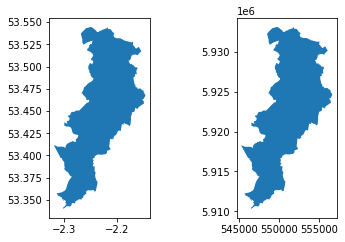

time: 483 ms (started: 2021-08-15 10:56:52 +02:00)


In [3]:
# load Milan city from openstreetmap using osmmnx api

city_name = 'Manchester, UK'
city = ox.geocode_to_gdf(city_name)
print('Milan coordinate reference system: ', city.crs)

# project to the local coordinate reference system
city_proj = ox.projection.project_gdf(city)
print('Projected Manchester coordinate reference system: ', city_proj.crs)

fig, (ax1, ax2) = plt.subplots(1, 2)
city.plot(ax=ax1, ec='none')
city_proj.plot(ax=ax2, ec='none' )
plt.tight_layout(pad=3.0)
plt.show()

In [4]:
# convert to "ESRI:54009" coordinate system, since that's the system NASA uses
city = city.to_crs("ESRI:54009") 
print(city.crs)

ESRI:54009
time: 232 ms (started: 2021-08-15 10:56:53 +02:00)


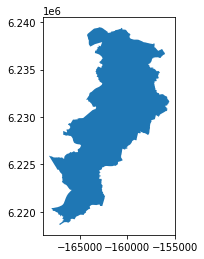

time: 113 ms (started: 2021-08-15 10:56:53 +02:00)


In [5]:
# plot city in new projection
ax = city.plot(ec='none')


In [6]:
# save to file
city.to_file('manchester_54009.shp')

time: 83.6 ms (started: 2021-08-15 10:56:53 +02:00)


<ipython-input-6-d942de6b0b24>:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  city.to_file('manchester_54009.shp')


In [7]:
# load the saved file
import fiona
with fiona.open("manchester_54009.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

time: 175 ms (started: 2021-08-15 10:56:53 +02:00)


In [8]:
# load the NASA population density raster file
# Data source: https://sedac.ciesin.columbia.edu/data/collection/gpw-v4
import rasterio.mask
with rasterio.open("data/GHS_POP_E2015_GLOBE_R2019A_54009_250_V1_0/GHS_POP_E2015_GLOBE_R2019A_54009_250_V1_0.tif") as src:
    # since the NASA data is for the entire world, we will use the 'shapes' polygon containing our city to mask out
    # the population raster data corresponding to our city
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True, nodata=0)
    out_meta = src.meta

time: 171 ms (started: 2021-08-15 10:56:53 +02:00)


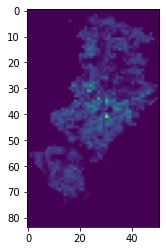

time: 117 ms (started: 2021-08-15 10:56:54 +02:00)


In [9]:
plt.imshow(out_image[0])

In [10]:
# since the raster array contains many dimensions, we assign the dimension containing the population density data to a new 
# variable
pop_density = out_image[0,:,:]
pop_density

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

time: 2.72 ms (started: 2021-08-15 10:56:54 +02:00)


In [11]:
# just in case, set all negative values to zero
pop_density[pop_density < 0] = 0

time: 422 µs (started: 2021-08-15 10:56:54 +02:00)


In [12]:
# split city into 400 x 400 meter grid cells
geometry = city_proj['geometry'].iloc[0]
print(type(geometry))
geometry_cut = ox.utils_geo._quadrat_cut_geometry(geometry, quadrat_width = 400)
print(type(geometry_cut))

<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
time: 4.82 s (started: 2021-08-15 10:56:54 +02:00)


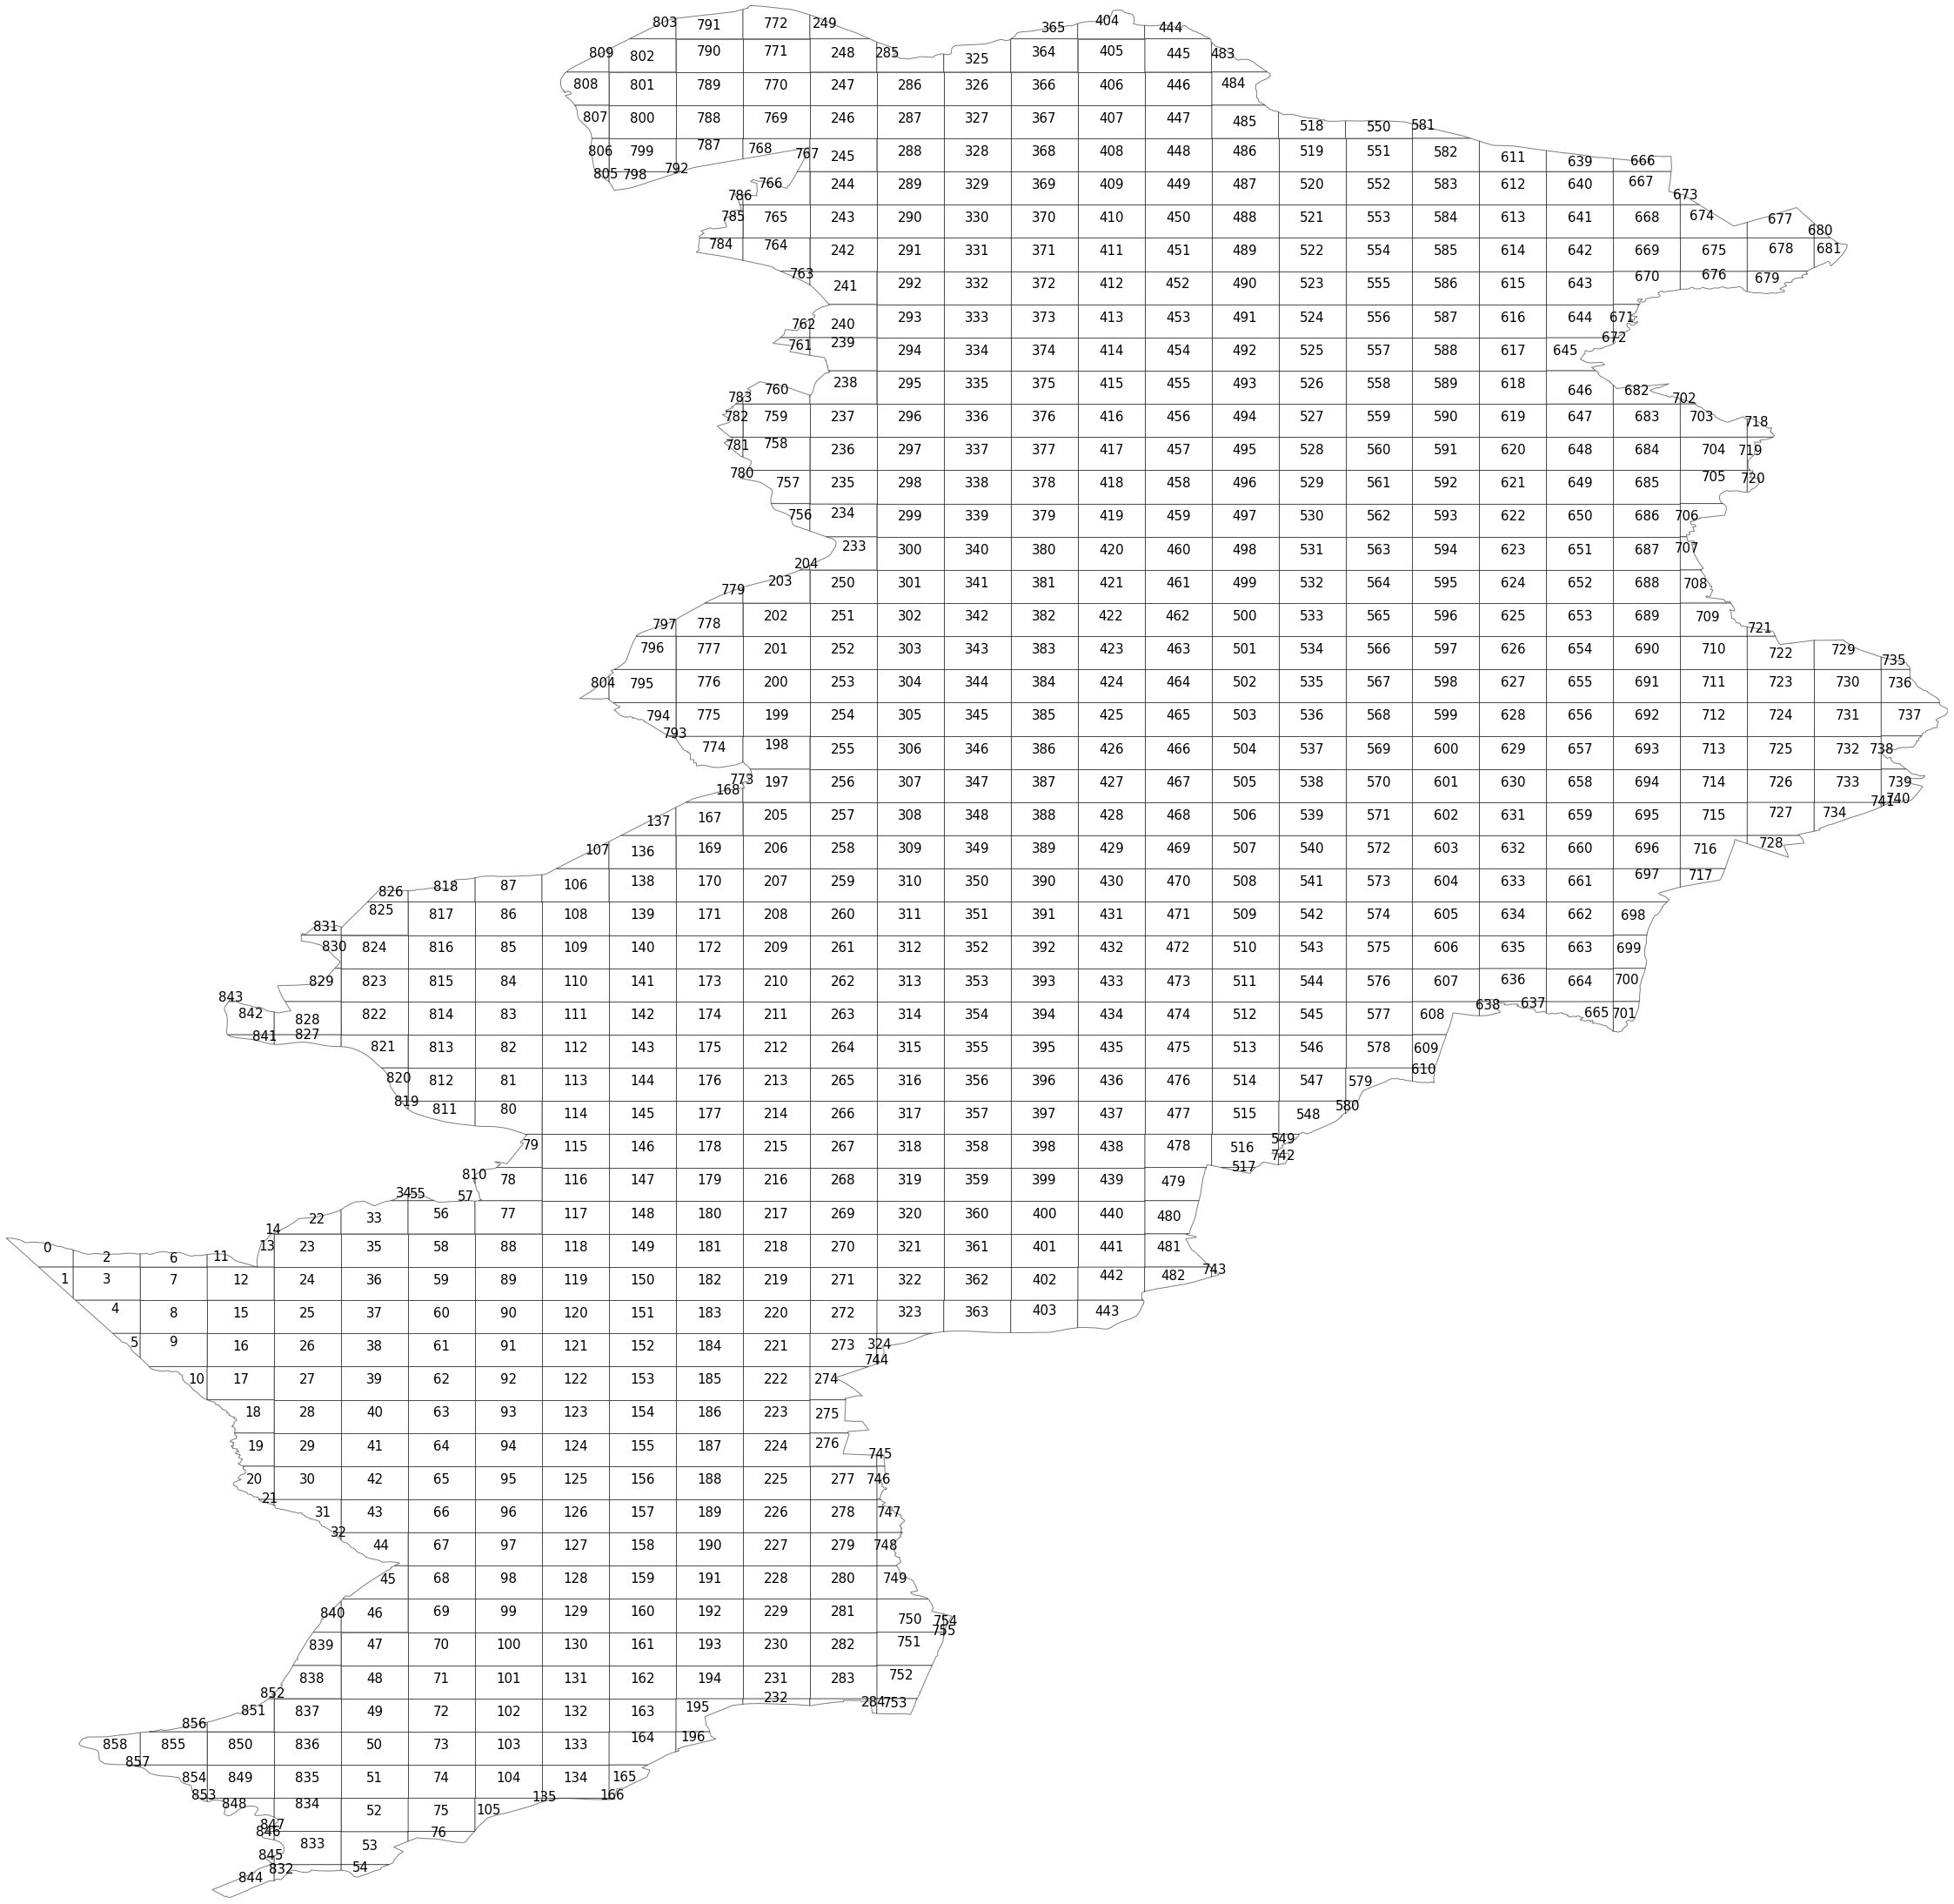

time: 4.18 s (started: 2021-08-15 10:56:59 +02:00)


In [13]:
polylist = [p for p in geometry_cut]

# plot city
west, south, east, north = city_proj.unary_union.bounds

fig, ax = plt.subplots(figsize=(40,40))
for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
    p = polygon.representative_point().coords[:][0]
    patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', alpha=0.5, zorder=2)
    ax.add_patch(patch)
    plt.annotate(text=n, xy=p, horizontalalignment='center', size=15)
    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

In [14]:
# create geodataframe from the square grid polygons
polyframe = gpd.GeoDataFrame(geometry=polylist)
polyframe.crs = city_proj.crs
print(polyframe.crs)
polyframe.head()

+proj=utm +zone=30 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs


geometry
0  POLYGON ((545204.981 5918275.469, 545240.927 5...
1  POLYGON ((545599.136 5917926.998, 545599.136 5...
2  POLYGON ((545599.136 5918132.236, 545607.733 5...
3  POLYGON ((545993.290 5917926.998, 545993.290 5...
4  POLYGON ((545993.290 5917527.310, 545993.290 5...

time: 25.3 ms (started: 2021-08-15 10:57:03 +02:00)


<AxesSubplot:>

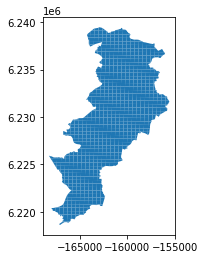

time: 511 ms (started: 2021-08-15 10:57:03 +02:00)


In [15]:
# convert to the NASA crs we introduced earlier
polyframe= polyframe.to_crs(city.crs)
polyframe.plot()

In [16]:
# load library for aggregating raster data into vector polygons
from rasterstats import zonal_stats

time: 60.1 ms (started: 2021-08-15 10:57:03 +02:00)


In [17]:
# compute the mean value of all raster values that fall into a given quadratic cell

affine = out_transform
city_stats = zonal_stats(polyframe, pop_density, affine=affine, stats='mean', nodata=0)
pop_array = np.array([list(item.values())[0] if list(item.values())[0] is not None else 0 for item in city_stats])
pop_array

array([1.80031036e+02, 3.18375336e+02, 1.72377518e+02, 1.52859222e+02,
       6.42901688e+01, 0.00000000e+00, 3.60594238e+02, 4.10642578e+02,
       3.91926857e+02, 3.63970795e+02, 4.87881683e+02, 3.50549805e+02,
       2.34254044e+02, 2.32772598e+02, 0.00000000e+00, 1.72917150e+02,
       2.32025818e+02, 1.54448096e+02, 2.43839485e+02, 8.72017517e+01,
       3.31710243e+01, 0.00000000e+00, 6.67811401e+02, 4.17530869e+02,
       4.06404663e+02, 2.73415141e+02, 1.20093452e+02, 4.42856846e+01,
       8.85146103e+01, 4.79171638e+01, 2.99370832e+01, 3.67654252e+00,
       0.00000000e+00, 4.15156616e+02, 0.00000000e+00, 3.65818512e+02,
       4.04119148e+01, 1.86639423e+02, 5.02805054e+02, 2.96406536e+02,
       1.58272146e+02, 2.85794584e+02, 2.40038193e+02, 1.82047829e+02,
       3.56799957e+02, 3.94234151e-01, 1.50850108e+00, 1.35176468e+00,
       2.51733175e+00, 2.36207223e+00, 6.91540620e-01, 0.00000000e+00,
       8.69678646e-01, 7.99813196e-02, 0.00000000e+00, 1.66872589e+02,
      

time: 839 ms (started: 2021-08-15 10:57:03 +02:00)


In [18]:
city_stats[:10]

[{'mean': 180.03103637695312},
 {'mean': 318.3753356933594},
 {'mean': 172.3775177001953},
 {'mean': 152.85922241210938},
 {'mean': 64.29016876220703},
 {'mean': None},
 {'mean': 360.59423828125},
 {'mean': 410.642578125},
 {'mean': 391.9268569946289},
 {'mean': 363.9707946777344}]

time: 2.11 ms (started: 2021-08-15 10:57:04 +02:00)


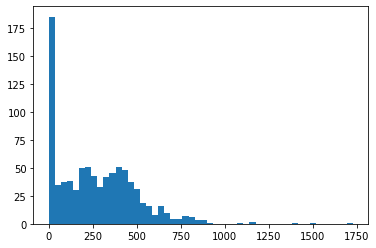

time: 273 ms (started: 2021-08-15 10:57:04 +02:00)


In [19]:
# plot histogram of the obtained population density values
plt.hist(pop_array, bins=50)
plt.show()

In [20]:
# assign the population values as a new column in the geodataframe with the grid cells, 
# so we know which grid cell has what population.

polyframe["population"] = pop_array
polyframe.head()

geometry  population
0  POLYGON ((-168240.611 6225920.279, -168201.483...  180.031036
1  POLYGON ((-167822.178 6225597.803, -167834.505...  318.375336
2  POLYGON ((-167815.417 6225785.697, -167806.282...  172.377518
3  POLYGON ((-167392.279 6225594.319, -167405.456...  152.859222
4  POLYGON ((-167405.456 6225228.399, -167418.633...   64.290169

time: 22.4 ms (started: 2021-08-15 10:57:05 +02:00)


(256, 4)
[[1.         0.96078431 0.94117647 1.        ]
 [0.99987697 0.95820069 0.93748558 1.        ]
 [0.99975394 0.95561707 0.93379469 1.        ]
 ...
 [0.41917724 0.00369089 0.05294887 1.        ]
 [0.4115494  0.00184544 0.05196463 1.        ]
 [0.40392157 0.         0.05098039 1.        ]]


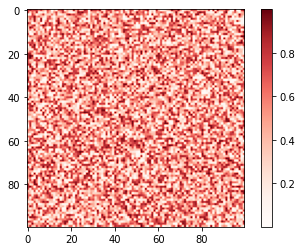

time: 189 ms (started: 2021-08-15 10:57:05 +02:00)


In [21]:
# in order to achieve a nice-looking visualisation, let's create a custom colormap, that fades away into transparency

ncolors = 256
# get cmap
color_array = plt.get_cmap('Reds')(range(ncolors))
print(color_array.shape)
print(color_array)

# change alpha values
color_array[:, -1] = np.linspace(0.3, 1, ncolors)

# create colormap object
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap

map_object = LinearSegmentedColormap.from_list(name="Reds_transp", colors=color_array)

# register the colormap object
plt.register_cmap(cmap=map_object)

# plot some example data
fig, ax = plt.subplots()
h = ax.imshow(np.random.rand(100,100), cmap='Reds_transp')
plt.colorbar(mappable=h)

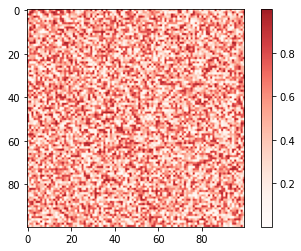

time: 166 ms (started: 2021-08-15 10:57:05 +02:00)


In [22]:
# let's cut it at the top for a better visual impact

def trunc_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list('trunc({n}, {a:.2f}, {b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
                                                cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('Reds_transp')
new_cmap = trunc_colormap(cmap, 0.0, .9)

# plot some example data
fig, ax = plt.subplots()
h = ax.imshow(np.random.rand(100,100), cmap=new_cmap)
plt.colorbar(mappable=h)

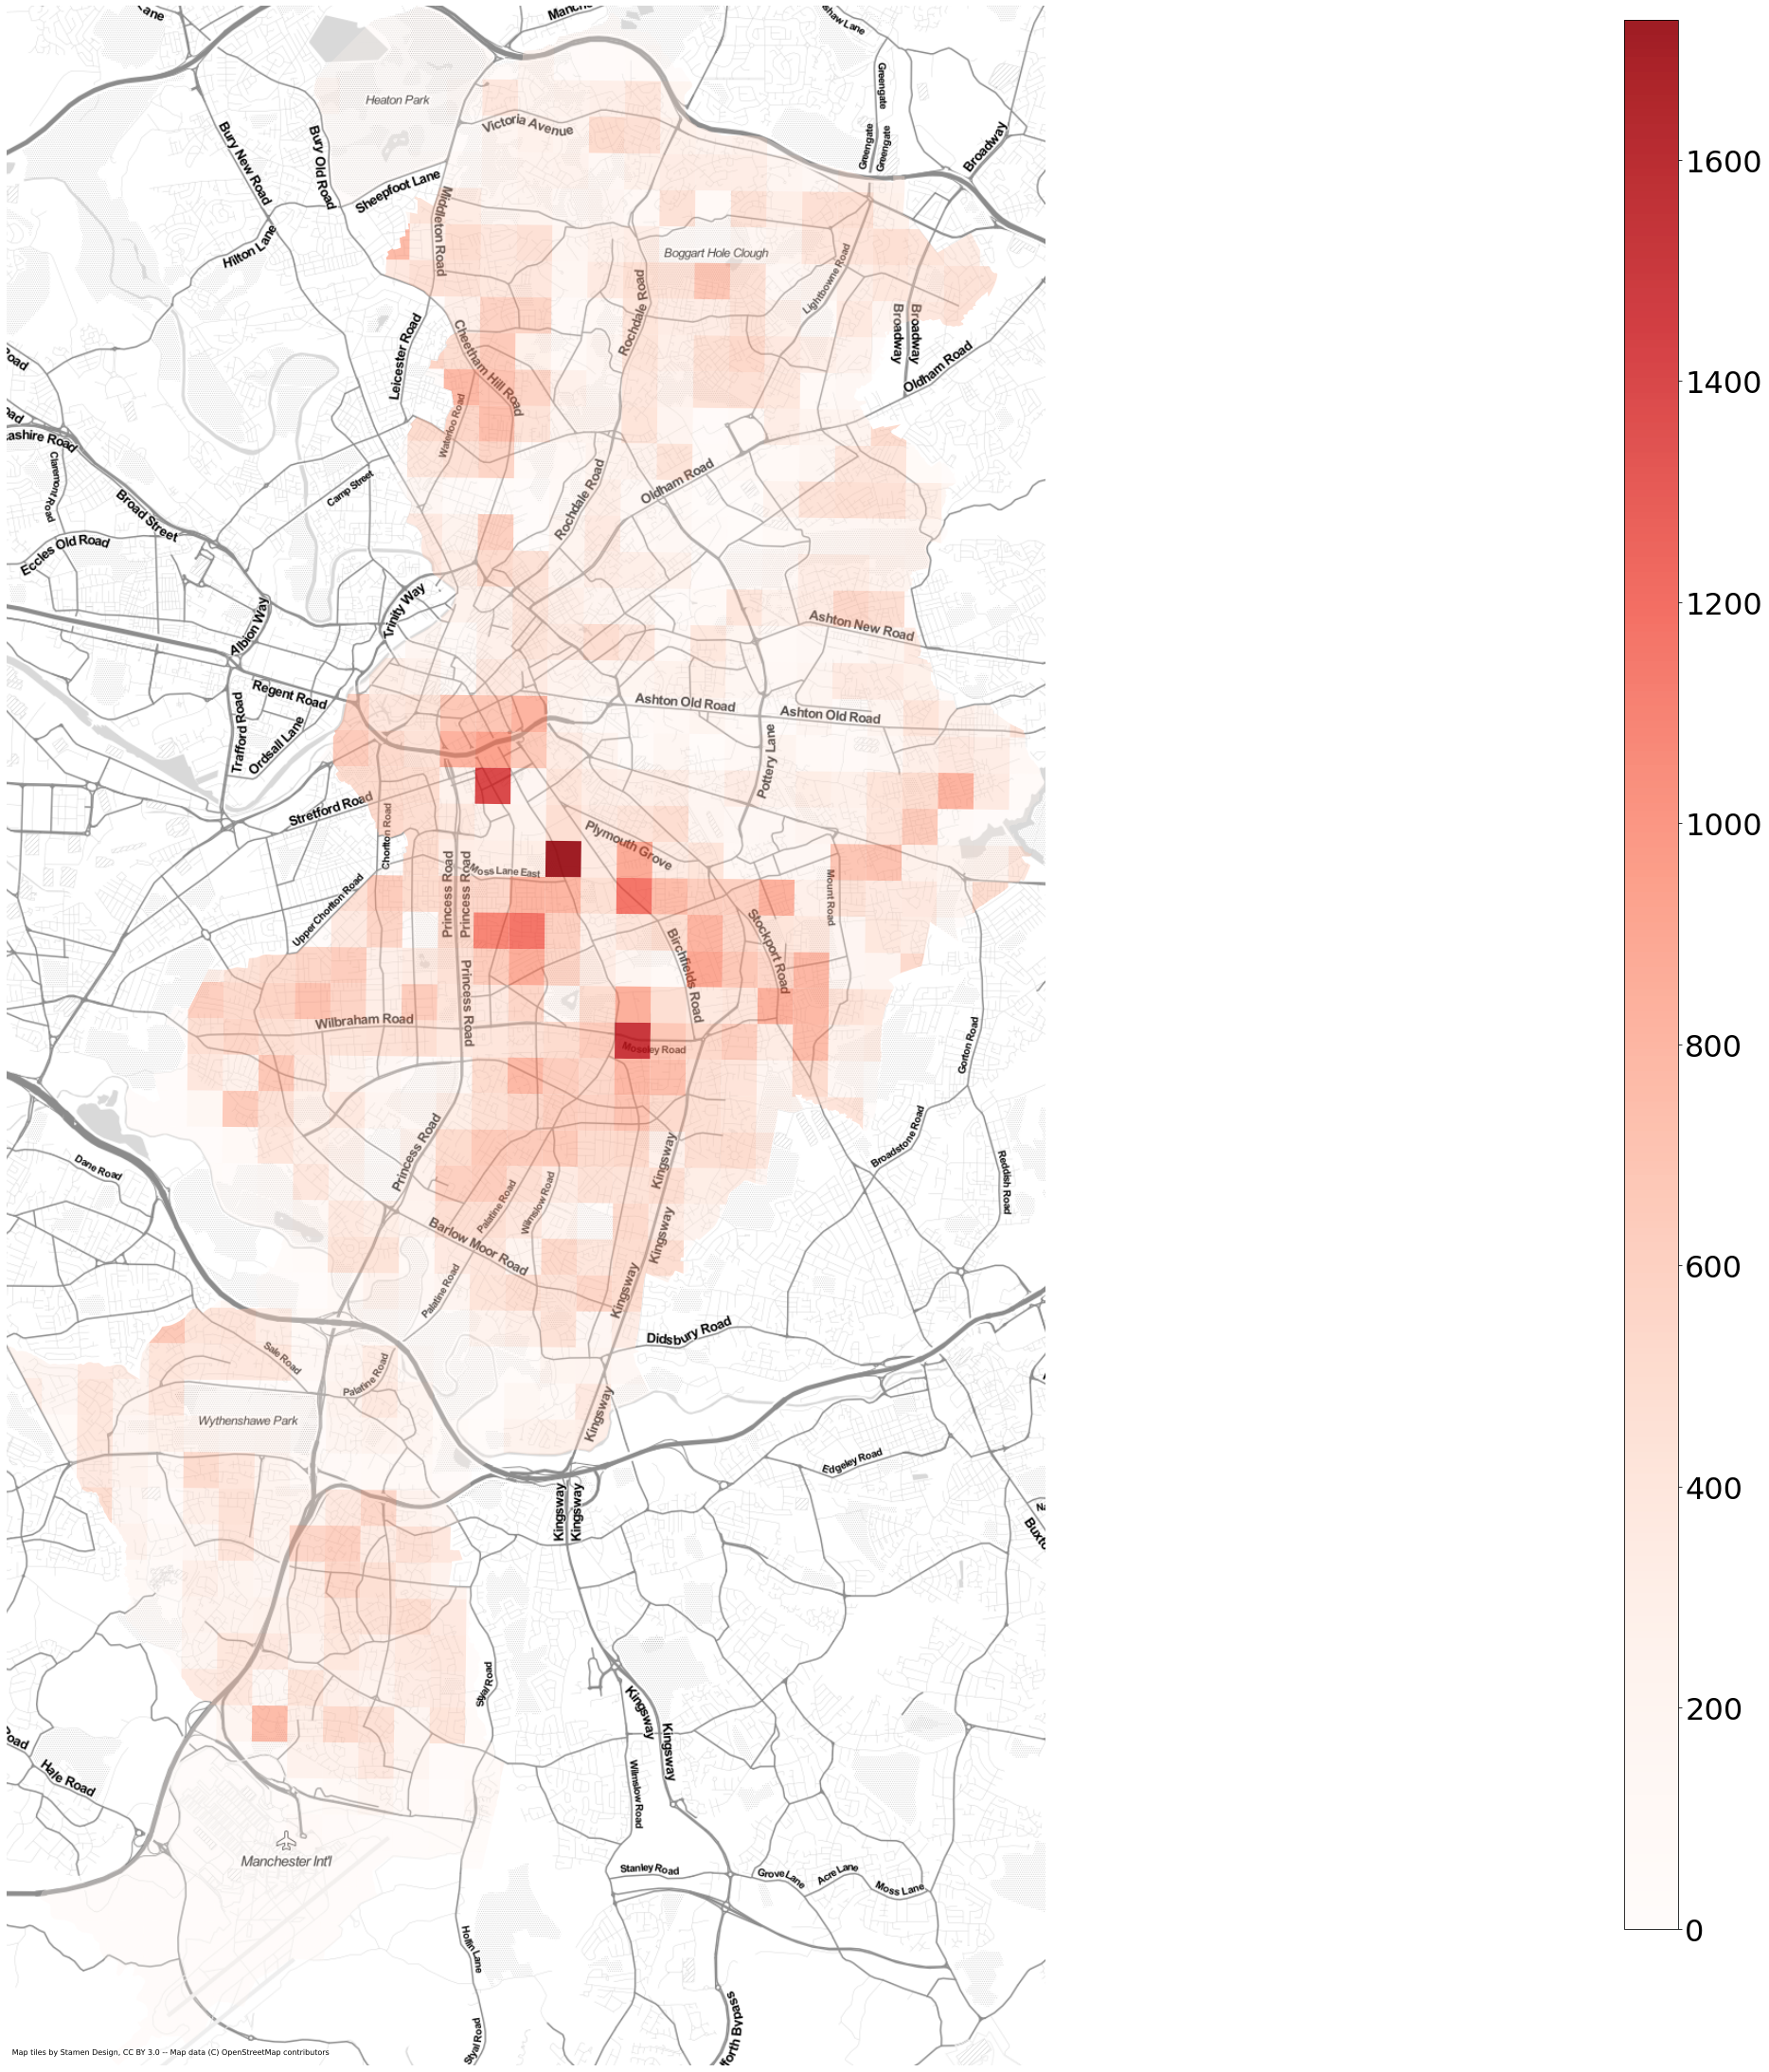

time: 11.2 s (started: 2021-08-15 10:57:05 +02:00)


In [23]:
# plot the population density data on a map background
plt.rcParams.update({'font.size':32})
import contextily as ctx
# ctx uses epsg:3857
polyframe_3857 = polyframe.to_crs(epsg=3857)
west, south, east, north = polyframe_3857.unary_union.bounds

#ax = polyframe_3857.plot(figsize=(40,40), alpha=0.5, edgecolor='k')
fig, ax = plt.subplots(figsize=(40,40))
polyframe_3857.plot(ax=ax, column = 'population', legend=False, cmap=new_cmap)

cbax = fig.add_axes([0.915, 0.175, 0.02, 0.7])

sm = plt.cm.ScalarMappable(cmap=new_cmap, \
                          norm = plt.Normalize(vmin=min(polyframe_3857.population), vmax=max(polyframe_3857.population)))

sm._A = []

# draw colormap into cbax

fig.colorbar(sm, cax=cbax, format="%d")

ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, zoom=13)
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

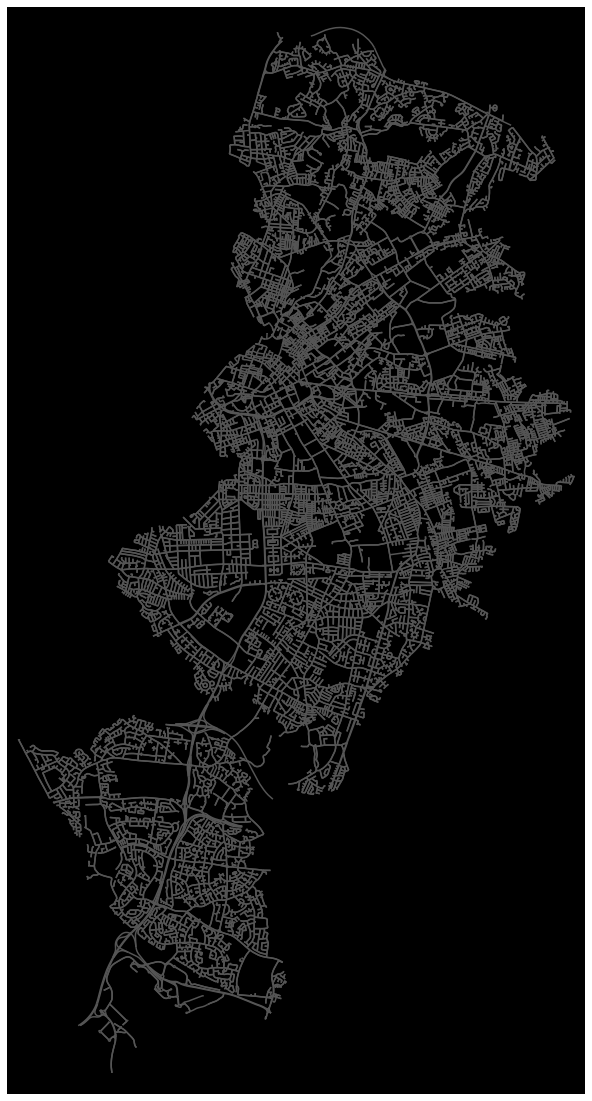

time: 23.8 s (started: 2021-08-15 10:57:16 +02:00)


In [24]:
# download and project a street network
G = ox.graph_from_place(city_name, network_type="drive")
#G = ox.project_graph(G)
fig, ax = ox.plot_graph(G, figsize=(20,20), bgcolor='k', node_size=0, node_color='#999999', node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=1.5, edge_alpha=1)

In [25]:
# set new coordinate reference system
from pyproj import CRS
crs = CRS.from_epsg(4326)
polyframe_gps = polyframe.to_crs(crs)
print(polyframe_gps.crs)

epsg:4326
time: 386 ms (started: 2021-08-15 10:57:40 +02:00)


<ipython-input-26-0e3ed00070c8>:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


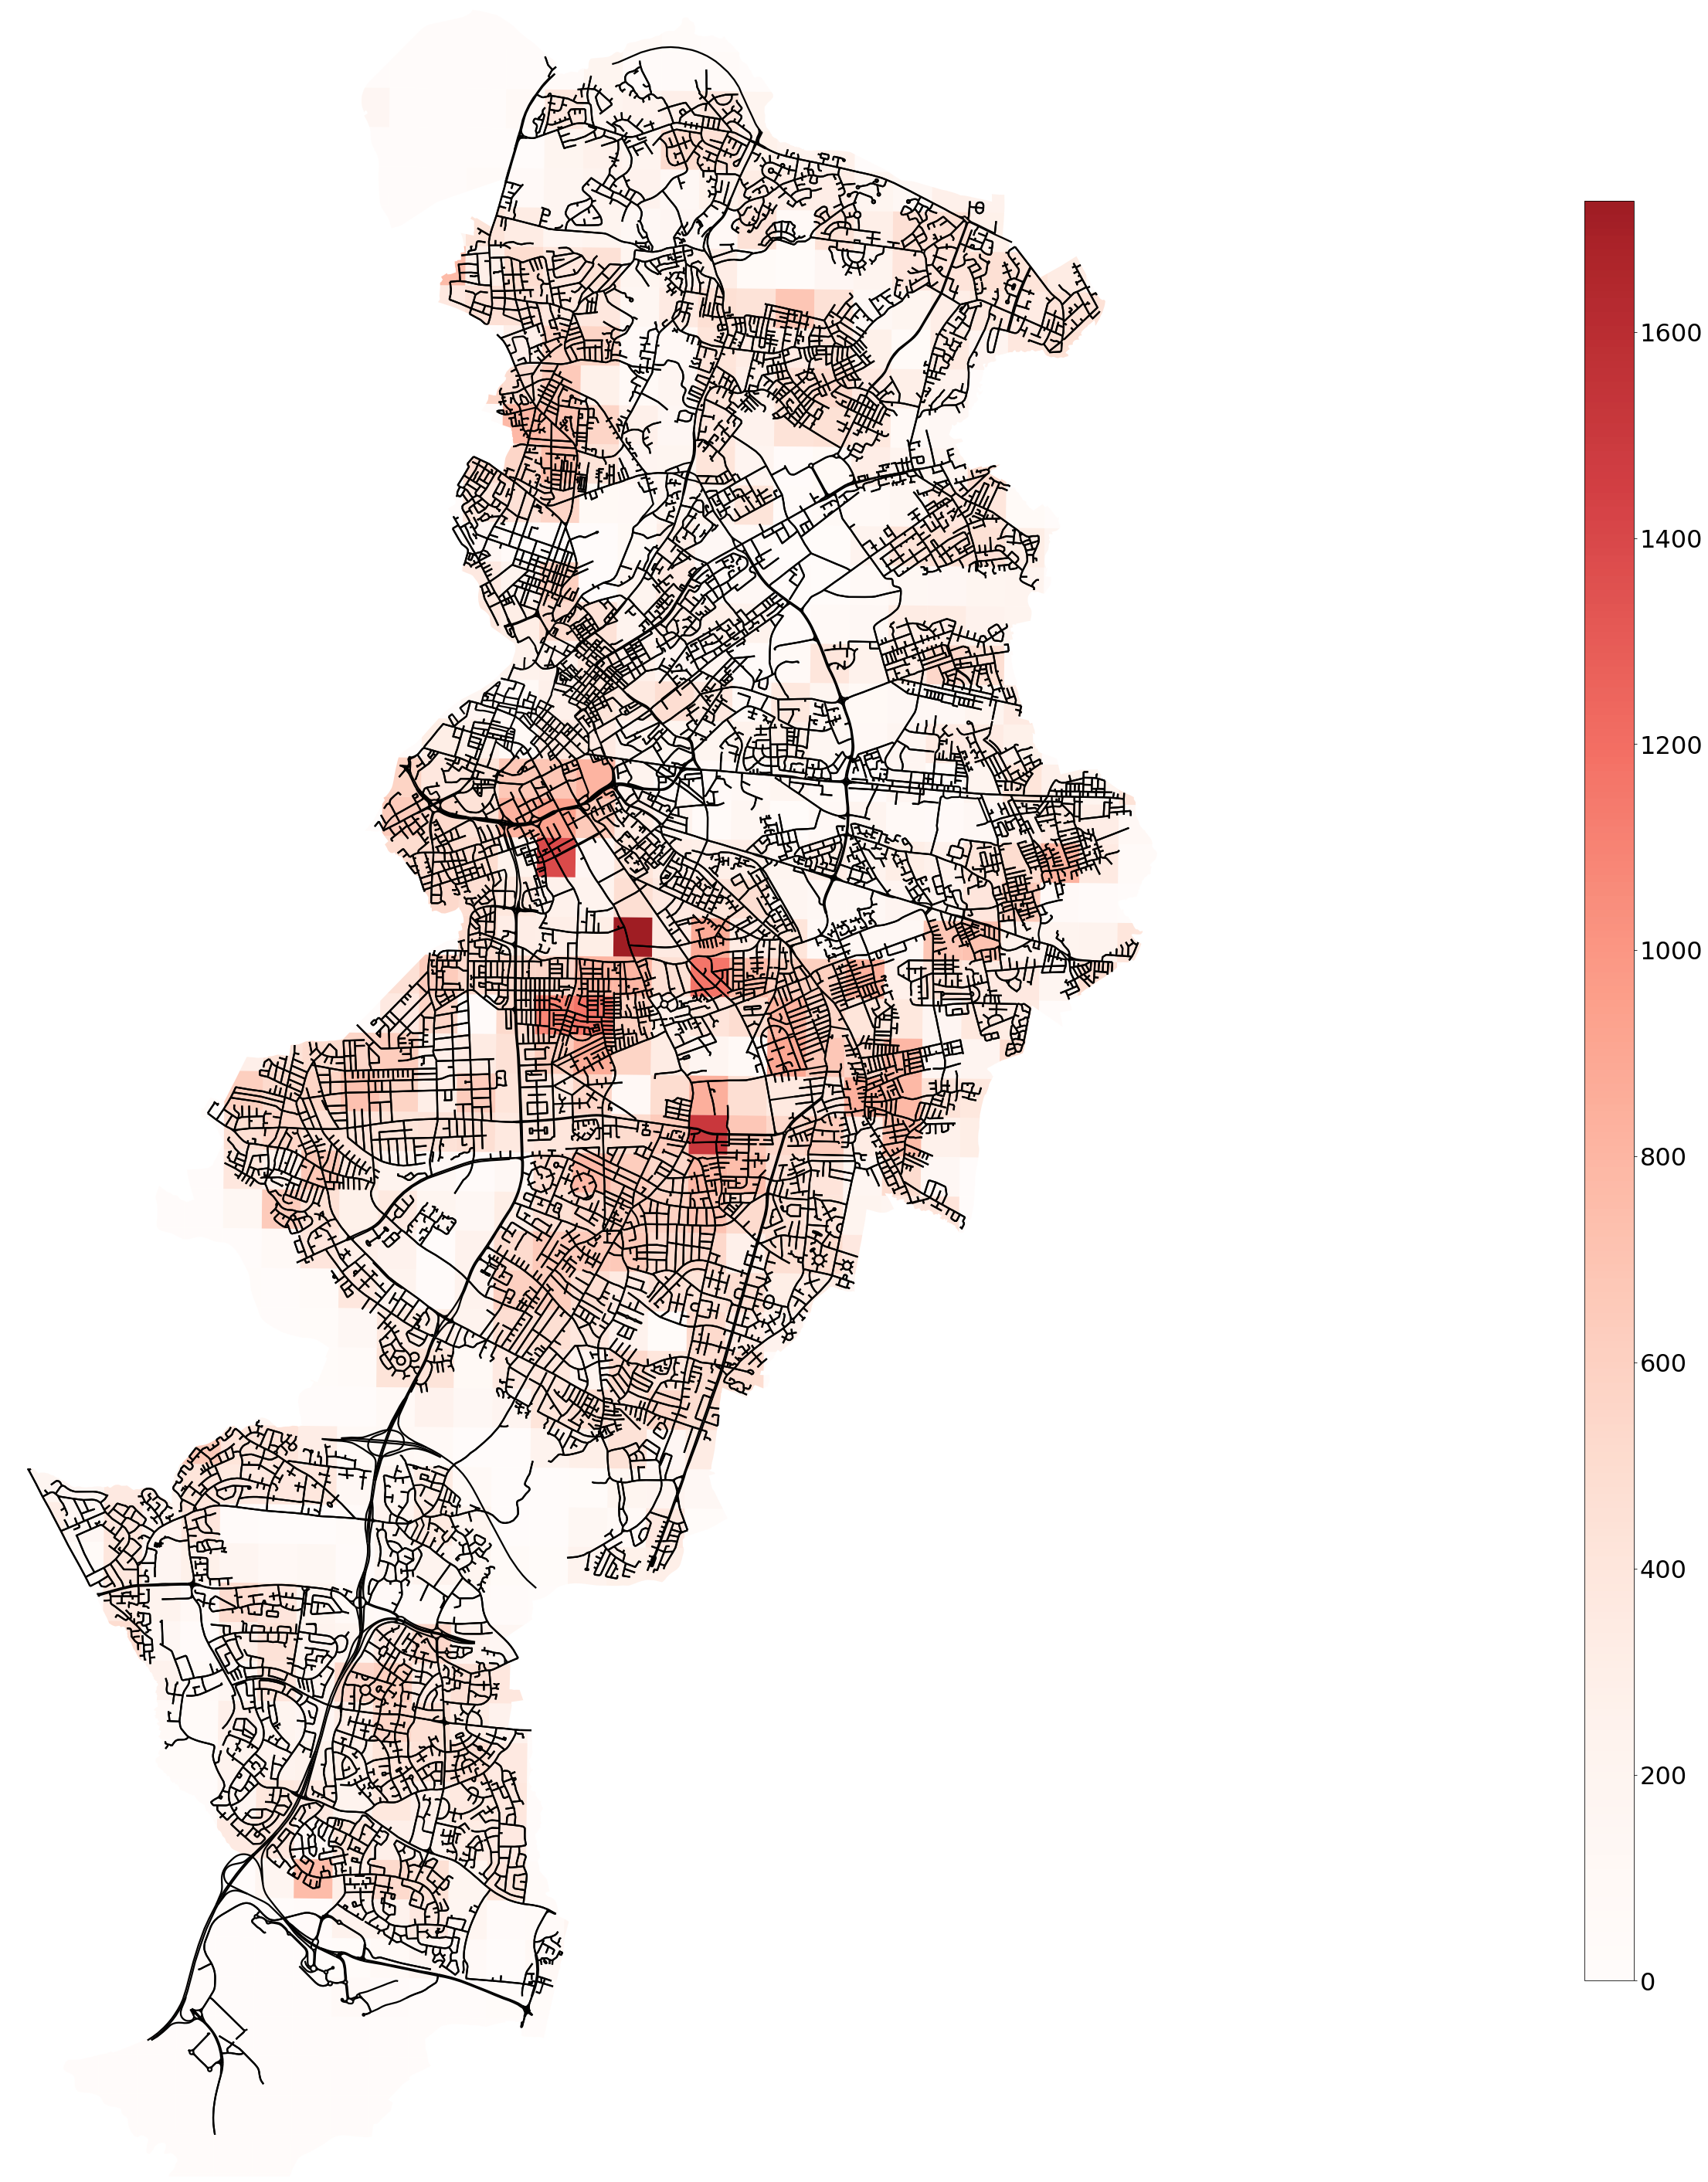

time: 9.28 s (started: 2021-08-15 10:57:40 +02:00)


In [26]:
fig, ax = plt.subplots(figsize=(40,40))

#plt.close()
polyframe_gps.plot(ax=ax, column = 'population', legend=False, cmap=new_cmap)

ox.plot_graph(G, ax=ax, figsize=(40,40),show=False, close=False, \
              node_color='grey', node_size=0, edge_linewidth=2.25, node_alpha=0.8, node_zorder=10,
              edge_color='black')

cbax = fig.add_axes([0.95, 0.1, 0.0225, 0.8])

sm = plt.cm.ScalarMappable(cmap=new_cmap, \
                          norm = plt.Normalize(vmin=min(polyframe_gps.population), vmax=max(polyframe_gps.population)))

sm._A = []

# draw colormap into cbax

fig.colorbar(sm, cax=cbax, format="%d")

ax.axis('off')
plt.tight_layout()
#plt.savefig('../data/Milan_pop_density_with_streets.jpg', dpi=150)
plt.show()

In [27]:
# let's get a list containing the street network node IDs
graph = G.nodes(data=True)
nodelist = [x[0] for x in graph]
nodelist[:10]

[234924,
 234929,
 234931,
 234933,
 234940,
 234948,
 234950,
 234952,
 234954,
 234955]

time: 4.21 ms (started: 2021-08-15 10:57:50 +02:00)


In [28]:
# then, we create a dataframe containing features of the street nodes (junctions)
from tqdm import tqdm
street_dict = {'osmid':[], 'lon':[], 'lat':[], 'street_count':[]}
for node in tqdm(nodelist):
    street_dict['osmid'].append(node)
    street_dict['lon'].append(graph[node]['x'])
    street_dict['lat'].append(graph[node]['y'])
    street_dict['street_count'].append(graph[node]['street_count'])
    
street_frame = pd.DataFrame(street_dict)
street_frame.head(10)

100%|██████████| 14663/14663 [00:00<00:00, 424121.98it/s]


osmid       lon        lat  street_count
0  234924 -2.301478  53.359347             3
1  234929 -2.290955  53.371717             3
2  234931 -2.285123  53.376408             3
3  234933 -2.275742  53.385792             3
4  234940 -2.268289  53.402140             3
5  234948 -2.266835  53.410414             3
6  234950 -2.262100  53.417853             3
7  234952 -2.257536  53.423616             3
8  234954 -2.252316  53.428652             4
9  234955 -2.251305  53.395586             3

time: 87.4 ms (started: 2021-08-15 10:57:50 +02:00)


In [29]:
# let's create Point geometries from the lat, lon pairs. 
geometry = [Point(xy) for xy in zip(street_frame.lon, street_frame.lat)]
street_frame = street_frame.drop(['lon', 'lat'], axis=1)
gdf = gpd.GeoDataFrame(street_frame, crs=crs, geometry=geometry)
gdf.tail()

osmid  street_count                   geometry
14658  8919774675             1  POINT (-2.26876 53.38349)
14659  8927710225             3  POINT (-2.24687 53.46985)
14660  8927710244             3  POINT (-2.24634 53.46984)
14661  8950745516             1  POINT (-2.22854 53.47005)
14662  8952001109             3  POINT (-2.22877 53.47624)

time: 354 ms (started: 2021-08-15 10:57:50 +02:00)


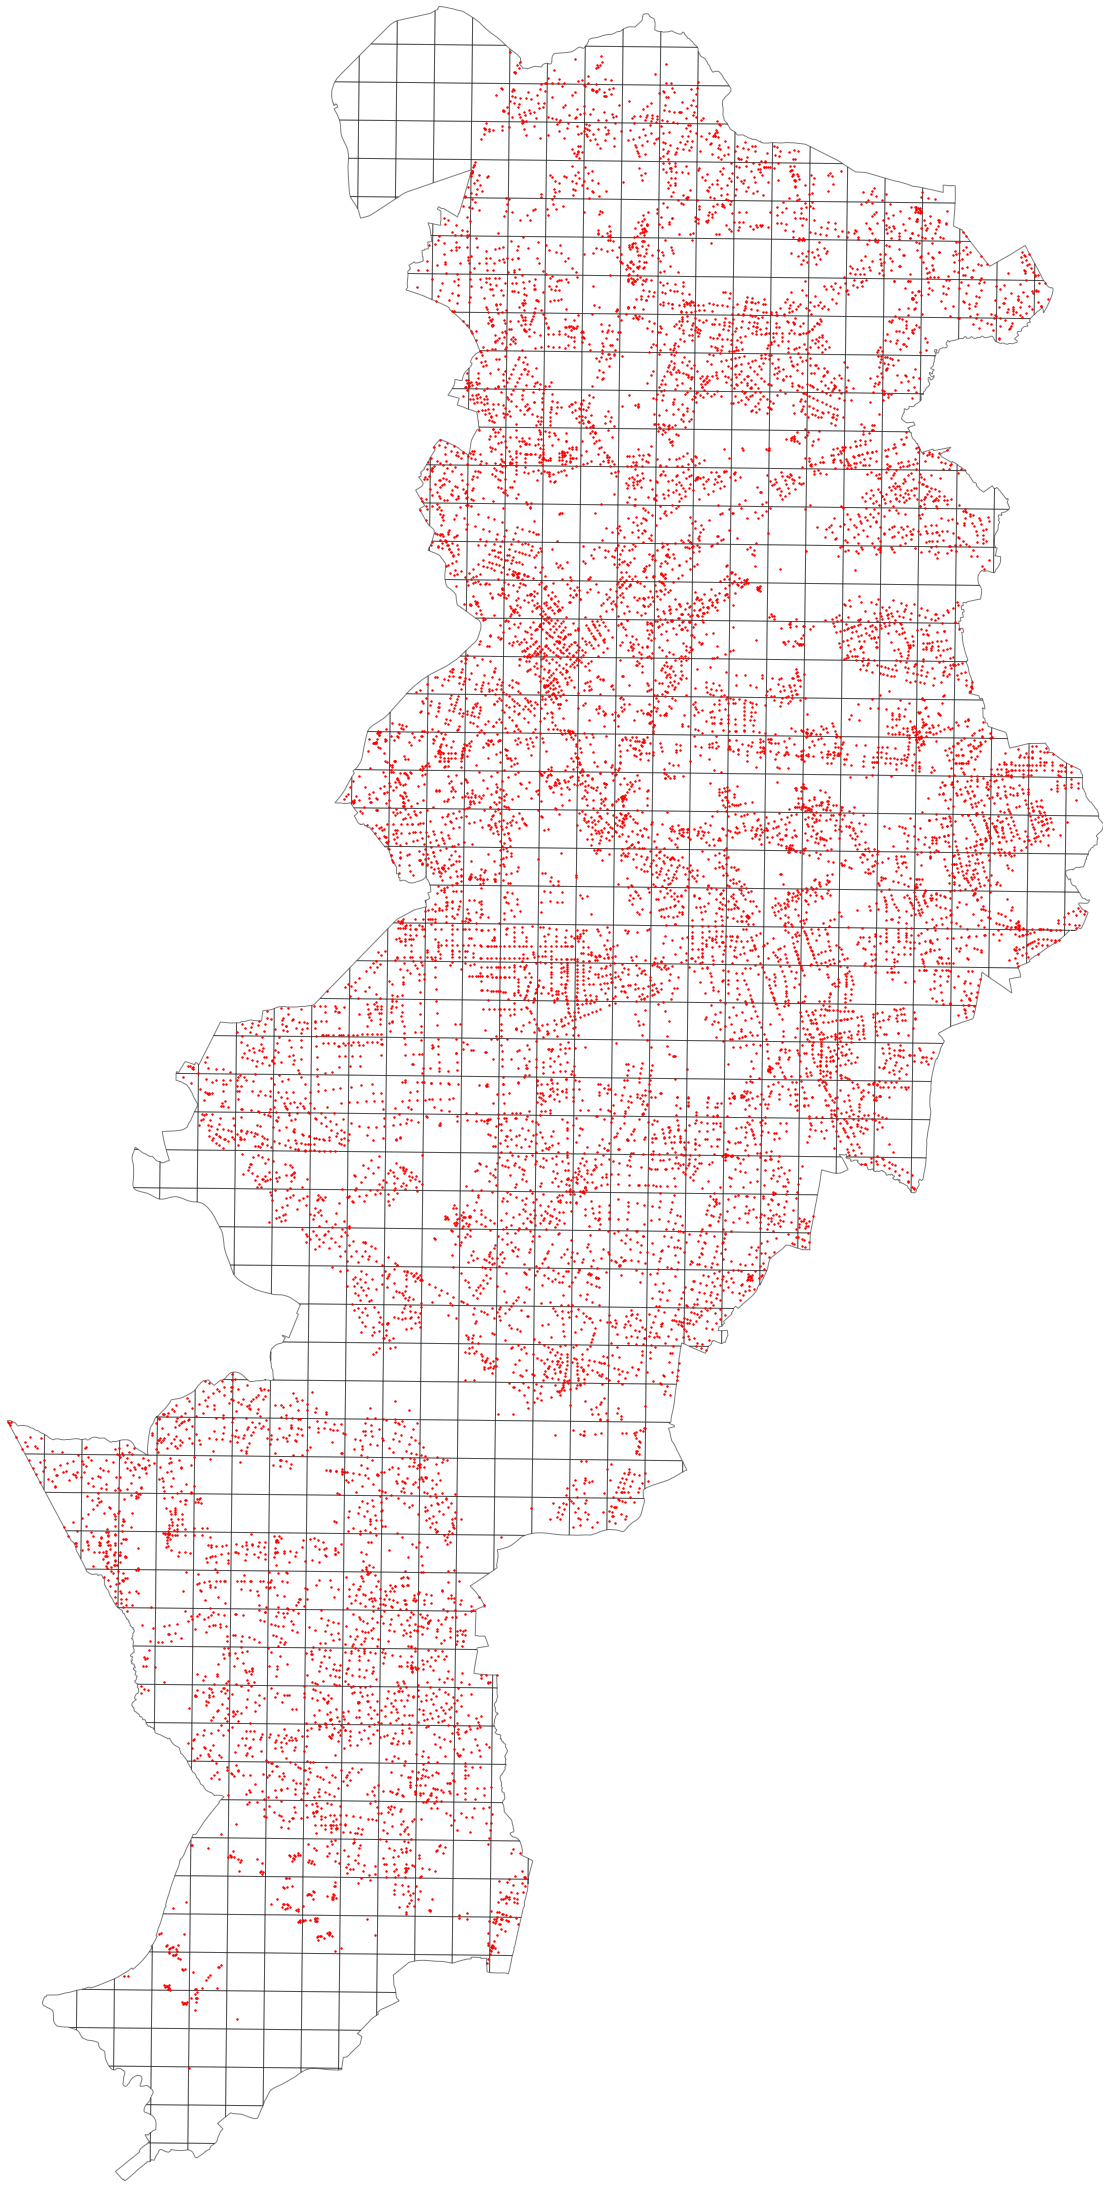

time: 2.61 s (started: 2021-08-15 10:57:50 +02:00)


In [30]:
west, south, east, north = polyframe_gps.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,40))
for polygon, n in zip(polyframe_gps.geometry, np.arange(len(polyframe_gps))):
    p = polygon.representative_point().coords[:][0]
    patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', alpha=0.5)
    ax.add_patch(patch)
#     plt.annotate(s=n, xy=p,
#                  horizontalalignment='center', size=7)
gdf.plot(ax=ax, color='red', markersize=2, zorder=2)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

In [31]:
pointInPoly = gpd.sjoin(polyframe_gps, gdf, op='contains')
print(len(pointInPoly))
pointInPoly.head(10)

14663


geometry  population  index_right  \
0  POLYGON ((-2.31992 53.41161, -2.31938 53.41158...  180.031036          811   
0  POLYGON ((-2.31992 53.41161, -2.31938 53.41158...  180.031036        12372   
0  POLYGON ((-2.31992 53.41161, -2.31938 53.41158...  180.031036        12371   
0  POLYGON ((-2.31992 53.41161, -2.31938 53.41158...  180.031036        14094   
0  POLYGON ((-2.31992 53.41161, -2.31938 53.41158...  180.031036          813   
0  POLYGON ((-2.31992 53.41161, -2.31938 53.41158...  180.031036         5716   
0  POLYGON ((-2.31992 53.41161, -2.31938 53.41158...  180.031036        12369   
0  POLYGON ((-2.31992 53.41161, -2.31938 53.41158...  180.031036         5728   
0  POLYGON ((-2.31992 53.41161, -2.31938 53.41158...  180.031036        12370   
0  POLYGON ((-2.31992 53.41161, -2.31938 53.41158...  180.031036         5727   

        osmid  street_count  
0    21709925             3  
0  1806307628             3  
0  1806307627             1  
0  6320200661             3  
0    21709928             3  
0    68966858             3  
0  1806299869             3  
0    68976994             3  
0  1806299872             1  
0    68976986             3

time: 767 ms (started: 2021-08-15 10:57:53 +02:00)


In [32]:
streetcounts = pointInPoly.groupby(pointInPoly.index)['index_right'].count()
counts = pd.DataFrame(streetcounts)
counts.columns = ['counts']
counts

counts
0        12
1         7
2         2
3        20
4         2
..      ...
837      19
838      12
839       2
840       1
851       2

[721 rows x 1 columns]

time: 8.8 ms (started: 2021-08-15 10:57:53 +02:00)


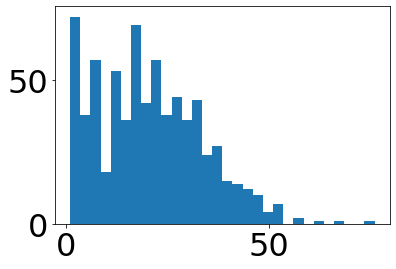

time: 110 ms (started: 2021-08-15 10:57:53 +02:00)


In [33]:
# a quick histogram of the street node counts
plt.hist(counts.counts, bins=30)
plt.show()

In [34]:
polycounts = polyframe_gps.copy()
polycounts['counts'] = counts.counts
polycounts['counts'].fillna(0, inplace=True)
polycounts['counts'] = polycounts['counts'].astype(int)
polycounts

geometry  population  counts
0    POLYGON ((-2.31992 53.41161, -2.31938 53.41158...  180.031036      12
1    POLYGON ((-2.31404 53.40844, -2.31409 53.40508...  318.375336       7
2    POLYGON ((-2.31401 53.41029, -2.31388 53.41022...  172.377518       2
3    POLYGON ((-2.30811 53.40841, -2.30817 53.40481...  152.859222      20
4    POLYGON ((-2.30817 53.40481, -2.30823 53.40122...   64.290169       2
..                                                 ...         ...     ...
854  POLYGON ((-2.30383 53.35090, -2.30398 53.35101...    0.000000       0
855  POLYGON ((-2.30898 53.35452, -2.30893 53.35802...    0.260885       0
856  POLYGON ((-2.30812 53.35811, -2.30765 53.35815...    0.000000       0
857  POLYGON ((-2.30899 53.35429, -2.30923 53.35435...    0.000000       0
858  POLYGON ((-2.31014 53.35453, -2.31033 53.35456...    0.415411       0

[859 rows x 3 columns]

time: 107 ms (started: 2021-08-15 10:57:54 +02:00)


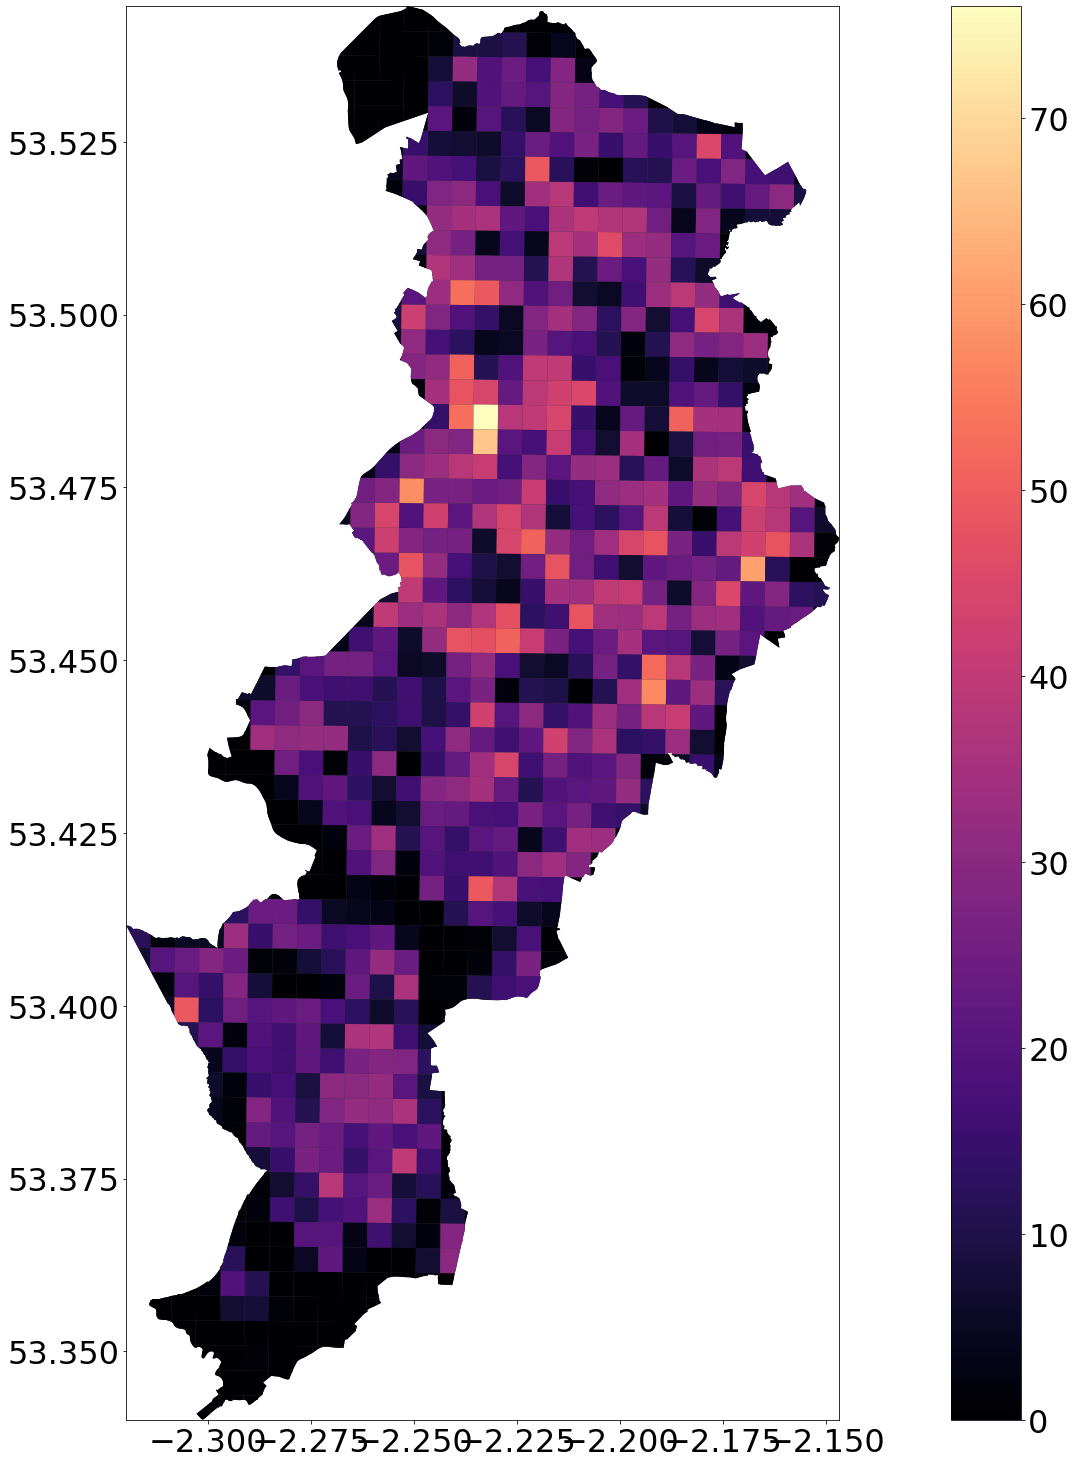

time: 907 ms (started: 2021-08-15 10:57:54 +02:00)


In [35]:
# plot the city street network density
west, south, east, north = polycounts.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))

polyframe_gps.plot(ax=ax, color='#000004')
polycounts.plot(column='counts',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

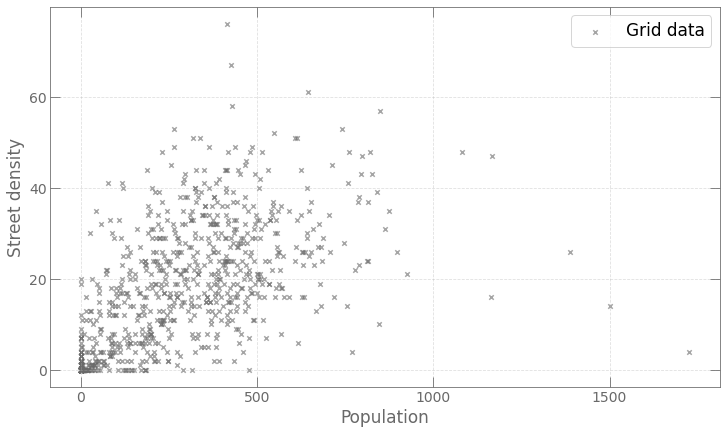

time: 126 ms (started: 2021-08-15 10:57:55 +02:00)


In [36]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.scatter(polycounts.population, polycounts.counts, alpha=0.6, color='dimgrey',\
           zorder=1, marker='x', label = "Grid data", s=20)

ax.legend(prop={'size': 17})
plt.xlabel('Population', size=17, color='dimgrey')
plt.ylabel('Street density', size=17, color='dimgrey', rotation=90)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(direction="in", size=10)
ax.spines['bottom'].set_color('dimgrey')
ax.spines['top'].set_color('dimgrey') 
ax.spines['right'].set_color('dimgrey')
ax.spines['left'].set_color('dimgrey')
ax.tick_params(axis='x', colors='dimgrey')
ax.tick_params(axis='y', colors='dimgrey')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.grid(alpha=0.4,ls='--')
# plt.savefig('pop_dens_milan.jpg', dpi=120)
plt.show()

In [37]:
np.corrcoef(polycounts.population,polycounts.counts)

array([[1.        , 0.60255962],
       [0.60255962, 1.        ]])

time: 2.38 ms (started: 2021-08-15 10:57:55 +02:00)


In [38]:
import pandana

time: 6.49 ms (started: 2021-08-15 10:57:55 +02:00)


In [39]:
from pandana.loaders import osm

import warnings
warnings.filterwarnings('ignore')

time: 809 µs (started: 2021-08-15 10:57:55 +02:00)


In [40]:
# get bounding box of city first
west, south, east, north = polycounts.unary_union.bounds
print(west, south, east, north)

-2.3199185 53.34010439999998 -2.1468288000000006 53.54459229999996
time: 143 ms (started: 2021-08-15 10:57:55 +02:00)


In [41]:
network = osm.pdna_network_from_bbox(south, west, north, east)

Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](53.34010440,-2.31991850,53.54459230,-2.14682880);>;);out;'}"
Downloaded 34,079.5KB from www.overpass-api.de in 4.47 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 5.28 seconds
Returning OSM data with 233,818 nodes and 56,998 ways...
Edge node pairs completed. Took 50.55 seconds
Returning processed graph with 72,347 nodes and 98,232 edges...
Completed OSM data download and Pandana node and edge table creation in 60.15 seconds
time: 1min 3s (started: 2021-08-15 10:57:55 +02:00)


In [42]:
network.nodes_df.head()

x          y
id                         
234952 -2.257536  53.423616
234954 -2.252316  53.428652
234971 -2.245778  53.435186
234972 -2.245260  53.435769
234976 -2.244991  53.453371

time: 6.09 ms (started: 2021-08-15 10:58:58 +02:00)


In [43]:
network.edges_df.head()

from          to    distance
234952 25444995    234952    25444995   82.747561
       3104061768  234952  3104061768  145.857460
234954 25445002    234954    25445002  410.867420
       25445101    234954    25445101   13.942861
234971 25445160    234971    25445160  204.523423

time: 8.78 ms (started: 2021-08-15 10:58:58 +02:00)


In [44]:
restaurants = osm.node_query(
    south, west, north, east, tags='"amenity"="restaurant"')

time: 836 ms (started: 2021-08-15 10:58:58 +02:00)


In [45]:
restaurants.head()

lat       lon   addr:city addr:housenumber addr:place  \
id                                                                       
27024694   53.410741 -2.230970  Manchester          844-846   Didsbury   
28889316   53.425482 -2.257432  Manchester              NaN        NaN   
31257652   53.434652 -2.264743  Manchester              NaN        NaN   
31622231   53.455527 -2.224932         NaN              NaN        NaN   
249231445  53.408895 -2.220793  Manchester              812        NaN   

          addr:postcode         addr:street     amenity  \
id                                                        
27024694        M20 2RN       Wilmslow Road  restaurant   
28889316        M21 7QS      Derwent Avenue  restaurant   
31257652        M21 7SP  Mauldeth Road West  restaurant   
31622231            NaN                 NaN  restaurant   
249231445       M20 5WY            Kingsway  restaurant   

                      contact:website cuisine  ... description  \
id                                             ...               
27024694   http://oliveandvine.co.uk/   greek  ...         NaN   
28889316                          NaN     NaN  ...         NaN   
31257652                          NaN  indian  ...         NaN   
31622231                          NaN   asian  ...         NaN   
249231445                         NaN  indian  ...         NaN   

          contact:instagram drink:beer toilets craft surveillance  \
id                                                                  
27024694                NaN        NaN     NaN   NaN          NaN   
28889316                NaN        NaN     NaN   NaN          NaN   
31257652                NaN        NaN     NaN   NaN          NaN   
31622231                NaN        NaN     NaN   NaN          NaN   
249231445               NaN        NaN     NaN   NaN          NaN   

          opening_hours:kitchen name:th diet:jain_vegetarian  \
id                                                             
27024694                    NaN     NaN                  NaN   
28889316                    NaN     NaN                  NaN   
31257652                    NaN     NaN                  NaN   
31622231                    NaN     NaN                  NaN   
249231445                   NaN     NaN                  NaN   

          opening_hours:covid19  
id                               
27024694                    NaN  
28889316                    NaN  
31257652                    NaN  
31622231                    NaN  
249231445                   NaN  

[5 rows x 94 columns]

time: 16.7 ms (started: 2021-08-15 10:58:59 +02:00)


In [46]:
restaurant_nodes = network.get_node_ids(restaurants.lon, restaurants.lat)
network.set(restaurant_nodes, 
            name = 'restaurants')

time: 13.4 ms (started: 2021-08-15 10:58:59 +02:00)


In [47]:
accessibility = network.aggregate(distance = 500,
                                  type = 'count',
                                  name = 'restaurants')
accessibility.describe()

count    72347.000000
mean         1.993476
std          8.420097
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max        110.000000
dtype: float64

time: 354 ms (started: 2021-08-15 10:58:59 +02:00)


In [48]:
accessibility.head()

id
234952    1.0
234954    0.0
234971    0.0
234972    0.0
234976    6.0
dtype: float64

time: 3.6 ms (started: 2021-08-15 10:58:59 +02:00)


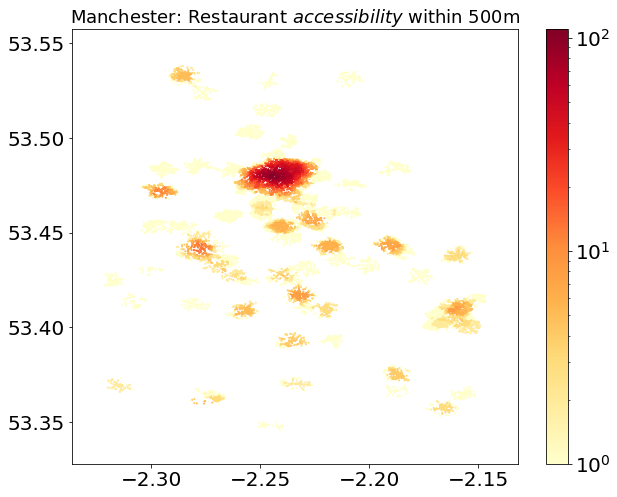

time: 1.02 s (started: 2021-08-15 10:58:59 +02:00)


In [49]:

import matplotlib
plt.rcParams.update({'font.size':20})
fig, ax = plt.subplots(figsize=(10,8))

plt.title('Manchester: Restaurant $accessibility$ within 500m', size = 18)
plt.scatter(network.nodes_df.x, network.nodes_df.y, 
            c=accessibility, s=1, cmap='YlOrRd', 
            norm=matplotlib.colors.LogNorm())
cb = plt.colorbar()

plt.show()

In [50]:
network_nodes = network.nodes_df
network_nodes.head()

x          y
id                         
234952 -2.257536  53.423616
234954 -2.252316  53.428652
234971 -2.245778  53.435186
234972 -2.245260  53.435769
234976 -2.244991  53.453371

time: 5.36 ms (started: 2021-08-15 10:59:00 +02:00)


In [51]:
network_nodes['accessibility'] = accessibility
network_nodes.head()

x          y  accessibility
id                                        
234952 -2.257536  53.423616            1.0
234954 -2.252316  53.428652            0.0
234971 -2.245778  53.435186            0.0
234972 -2.245260  53.435769            0.0
234976 -2.244991  53.453371            6.0

time: 7.12 ms (started: 2021-08-15 10:59:00 +02:00)


In [52]:
geometry = [Point(xy) for xy in zip(network_nodes.x, network_nodes.y)]
network_nodes = network_nodes.drop(['x', 'y'], axis=1)
network_gdf = gpd.GeoDataFrame(network_nodes, crs=crs, geometry=geometry)
network_gdf.head()

accessibility                   geometry
id                                              
234952            1.0  POINT (-2.25754 53.42362)
234954            0.0  POINT (-2.25232 53.42865)
234971            0.0  POINT (-2.24578 53.43519)
234972            0.0  POINT (-2.24526 53.43577)
234976            6.0  POINT (-2.24499 53.45337)

time: 1.55 s (started: 2021-08-15 10:59:00 +02:00)


In [53]:
len(network_gdf)

72347

time: 1.66 ms (started: 2021-08-15 10:59:02 +02:00)


In [54]:
pointInPoly = gpd.sjoin(polyframe_gps, network_gdf, op='contains')

time: 1.82 s (started: 2021-08-15 10:59:02 +02:00)


In [55]:

print(len(pointInPoly))
pointInPoly.head(10)

32920


geometry  population  index_right  \
0  POLYGON ((-2.31992 53.41161, -2.31938 53.41158...  180.031036     21709928   
0  POLYGON ((-2.31992 53.41161, -2.31938 53.41158...  180.031036     68966858   
0  POLYGON ((-2.31992 53.41161, -2.31938 53.41158...  180.031036   1806299869   
0  POLYGON ((-2.31992 53.41161, -2.31938 53.41158...  180.031036     68976994   
0  POLYGON ((-2.31992 53.41161, -2.31938 53.41158...  180.031036   4159194548   
0  POLYGON ((-2.31992 53.41161, -2.31938 53.41158...  180.031036     68976986   
0  POLYGON ((-2.31992 53.41161, -2.31938 53.41158...  180.031036     21709927   
0  POLYGON ((-2.31992 53.41161, -2.31938 53.41158...  180.031036   1265917261   
0  POLYGON ((-2.31992 53.41161, -2.31938 53.41158...  180.031036   1265916932   
0  POLYGON ((-2.31992 53.41161, -2.31938 53.41158...  180.031036   1265917472   

   accessibility  
0            0.0  
0            0.0  
0            0.0  
0            0.0  
0            0.0  
0            0.0  
0            0.0  
0            0.0  
0            0.0  
0            0.0

time: 22.4 ms (started: 2021-08-15 10:59:04 +02:00)


In [68]:
aggr_access = pointInPoly.groupby(pointInPoly.index)['accessibility'].mean()
aggr_access_df = pd.DataFrame(aggr_access)
aggr_access_df.columns = ['aggr_access']
aggr_access_df.max()

aggr_access    82.269565
dtype: float64

time: 6.22 ms (started: 2021-08-15 10:59:50 +02:00)


In [69]:
aggr_access_df.value_counts()

aggr_access
0.000000       534
1.000000         9
0.416667         4
0.400000         3
0.241379         2
              ... 
0.560000         1
0.574074         1
0.580000         1
0.583333         1
82.269565        1
Length: 248, dtype: int64

time: 7.88 ms (started: 2021-08-15 10:59:52 +02:00)


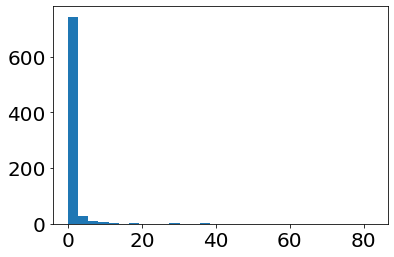

time: 137 ms (started: 2021-08-15 10:59:53 +02:00)


In [70]:
# a quick histogram of the aggregated accessibility
plt.hist(aggr_access_df.aggr_access, bins=30)
plt.show()

In [71]:
polyaccess = polyframe_gps.copy()
polyaccess['aggr_access'] = aggr_access_df.aggr_access
polyaccess['aggr_access'].fillna(0, inplace=True)
#polyaccess['aggr_access'] = polyaccess['aggr_access'].astype(int)
polyaccess

geometry  population  \
0    POLYGON ((-2.31992 53.41161, -2.31938 53.41158...  180.031036   
1    POLYGON ((-2.31404 53.40844, -2.31409 53.40508...  318.375336   
2    POLYGON ((-2.31401 53.41029, -2.31388 53.41022...  172.377518   
3    POLYGON ((-2.30811 53.40841, -2.30817 53.40481...  152.859222   
4    POLYGON ((-2.30817 53.40481, -2.30823 53.40122...   64.290169   
..                                                 ...         ...   
854  POLYGON ((-2.30383 53.35090, -2.30398 53.35101...    0.000000   
855  POLYGON ((-2.30898 53.35452, -2.30893 53.35802...    0.260885   
856  POLYGON ((-2.30812 53.35811, -2.30765 53.35815...    0.000000   
857  POLYGON ((-2.30899 53.35429, -2.30923 53.35435...    0.000000   
858  POLYGON ((-2.31014 53.35453, -2.31033 53.35456...    0.415411   

     aggr_access  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  
..           ...  
854          0.0  
855          0.0  
856          0.0  
857          0.0  
858          0.0  

[859 rows x 3 columns]

time: 108 ms (started: 2021-08-15 10:59:59 +02:00)


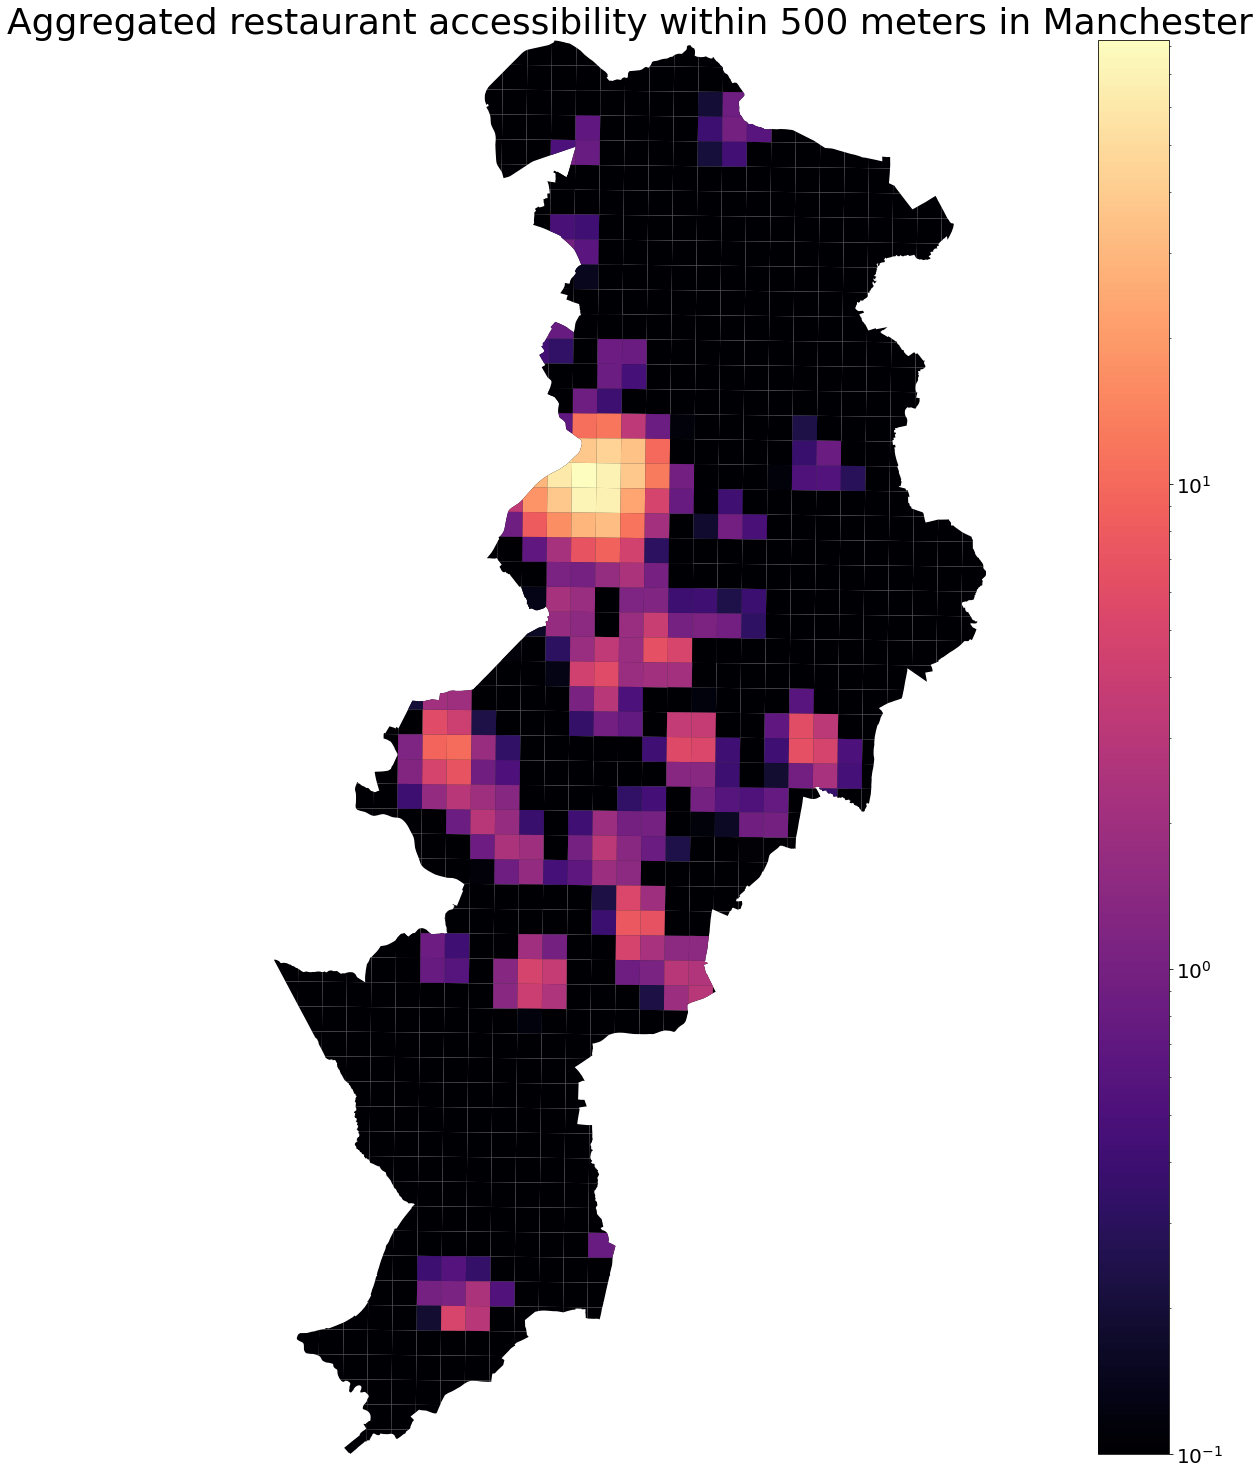

time: 920 ms (started: 2021-08-15 11:00:02 +02:00)


In [72]:
# plot the city aggregated accessibility

LOGMIN = 0.1  # arbitrary lower bound, as appropriate for log-scaled data display
west, south, east, north = polyaccess.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))

polyframe_gps.plot(ax=ax, color='#000004')
polyaccess.plot(column='aggr_access',  legend=True, \
    norm=matplotlib.colors.LogNorm(vmin=max(polyaccess.aggr_access.min(), LOGMIN), \
                                   vmax=polyaccess.aggr_access.max()), \
                                    cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
plt.title("Aggregated restaurant accessibility within 500 meters in Manchester", size = 36)
ax.axis('off')
plt.show()

In [73]:
polyaccess["pop_int"] = polyaccess.population.astype(int) + 1
polyaccess.head()

geometry  population  aggr_access  \
0  POLYGON ((-2.31992 53.41161, -2.31938 53.41158...  180.031036          0.0   
1  POLYGON ((-2.31404 53.40844, -2.31409 53.40508...  318.375336          0.0   
2  POLYGON ((-2.31401 53.41029, -2.31388 53.41022...  172.377518          0.0   
3  POLYGON ((-2.30811 53.40841, -2.30817 53.40481...  152.859222          0.0   
4  POLYGON ((-2.30817 53.40481, -2.30823 53.40122...   64.290169          0.0   

   pop_int  
0      181  
1      319  
2      173  
3      153  
4       65

time: 23.3 ms (started: 2021-08-15 11:00:09 +02:00)


In [74]:
polyaccess["access_normalised"] = polyaccess.aggr_access / polyaccess.pop_int 
polyaccess.head(200)

geometry  population  \
0    POLYGON ((-2.31992 53.41161, -2.31938 53.41158...  180.031036   
1    POLYGON ((-2.31404 53.40844, -2.31409 53.40508...  318.375336   
2    POLYGON ((-2.31401 53.41029, -2.31388 53.41022...  172.377518   
3    POLYGON ((-2.30811 53.40841, -2.30817 53.40481...  152.859222   
4    POLYGON ((-2.30817 53.40481, -2.30823 53.40122...   64.290169   
..                                                 ...         ...   
195  POLYGON ((-2.25557 53.36138, -2.25558 53.36077...    1.111939   
196  POLYGON ((-2.25855 53.35781, -2.25845 53.35734...    0.198724   
197  POLYGON ((-2.25384 53.45990, -2.25369 53.45993...  506.961578   
198  POLYGON ((-2.25317 53.46197, -2.25326 53.46216...  479.771988   
199  POLYGON ((-2.25374 53.46556, -2.25368 53.46916...  494.904388   

     aggr_access  pop_int  access_normalised  
0       0.000000      181           0.000000  
1       0.000000      319           0.000000  
2       0.000000      173           0.000000  
3       0.000000      153           0.000000  
4       0.000000       65           0.000000  
..           ...      ...                ...  
195     0.000000        2           0.000000  
196     0.000000        1           0.000000  
197     1.734940      507           0.003422  
198     2.216049      480           0.004617  
199     1.099174      495           0.002221  

[200 rows x 5 columns]

time: 108 ms (started: 2021-08-15 11:00:10 +02:00)


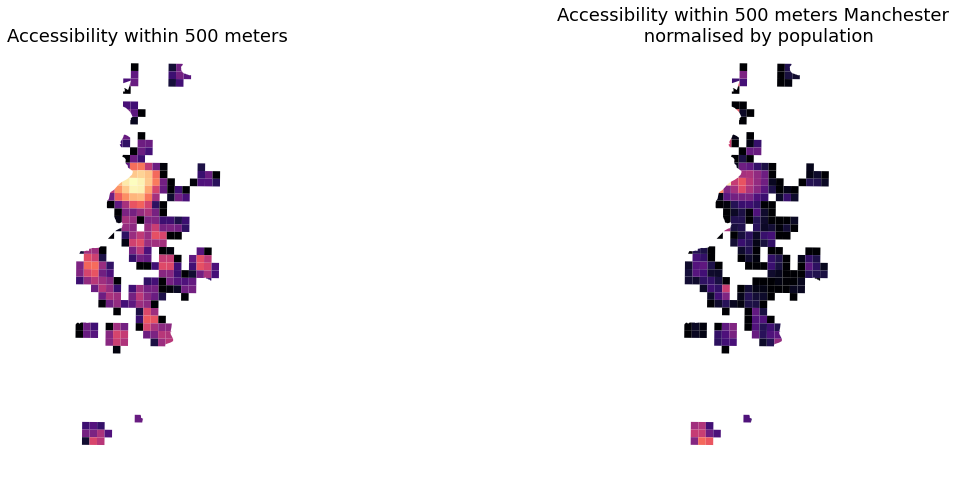

time: 599 ms (started: 2021-08-15 11:00:18 +02:00)


In [76]:
f, ax = plt.subplots(1,2,figsize=(20,8))

polyaccess.plot(column='aggr_access', ax = ax[0], \
    norm=matplotlib.colors.LogNorm(vmin=max(polyaccess.aggr_access.min(), LOGMIN), \
                                   vmax=polyaccess.aggr_access.max()), \
                                    cmap='magma')   
  
ax[0].axis(polyaccess.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("Accessibility within 500 meters", size = 18)


polyaccess.plot(column='access_normalised', ax = ax[1], \
    norm=matplotlib.colors.LogNorm(vmin=max(polyaccess.access_normalised.min(), 0.001), \
                                   vmax=polyaccess.access_normalised.max()), \
                                    cmap='magma')

ax[1].axis(polyaccess.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Accessibility within 500 meters Manchester \n normalised by population", size = 18)
ax[0].axis('off')
ax[1].axis('off')
plt.show()

In [77]:
sum(polyaccess.access_normalised)

94.81329774008151

time: 2.15 ms (started: 2021-08-15 11:00:42 +02:00)


In [78]:
#final score
polyaccess.access_normalised.mean()

0.11037636523874449

time: 2.23 ms (started: 2021-08-15 11:00:43 +02:00)


In [79]:
polyaccess.aggr_access.mean()

1.3635287142164458

time: 2.25 ms (started: 2021-08-15 11:00:44 +02:00)


In [80]:
sum(polyaccess.pop_int)

232448

time: 4.42 ms (started: 2021-08-15 12:10:15 +02:00)


In [83]:
sum(polyaccess.access_normalised)

94.81329774008151

time: 2.17 ms (started: 2021-08-16 16:02:53 +02:00)
